In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

NUM_CLASSES = 3       # 사과, 바나나, 포도
BATCH_SIZE = 64       # 한 번에 학습할 문제 수
LEARNING_RATE = 0.001 # 학습 속도
EPOCHS = 5            # 반복 횟수

# ==========================================
# 1. 데이터 로드 및 전처리
# ==========================================

# 1. 파일 불러오기
# Quick Draw 데이터는 개수가 아주 많으므로, 학습 속도를 위해 각 3,000개씩만 자름
apple_raw = np.load('full_numpy_bitmap_apple.npy')[:3000]
banana_raw = np.load('full_numpy_bitmap_banana.npy')[:3000]
grapes_raw = np.load('full_numpy_bitmap_grapes.npy')[:3000]

print(f"사과 개수: {len(apple_raw)}, 바나나 개수: {len(banana_raw)}, 포도 개수: {len(grapes_raw)}")

# 2. 데이터 합치기 (사과 -> 바나나 -> 포도 순서로)
X_data = np.concatenate([apple_raw, banana_raw, grapes_raw], axis=0)

# 3. 정답 만들기
# 0: 사과, 1: 바나나, 2: 포도
y_data = np.array([0]*3000 + [1]*3000 + [2]*3000)

# 4. 데이터 전처리
# 이미지 픽셀값(0~255)을 0~1 사이 소수로 변환
X_data = X_data.astype(np.float32) / 255.0

# 1줄로 펴진 그림(784)을 다시 28x28 이미지로 복원
# (개수, 채널, 세로, 가로) -> (9000, 1, 28, 28)
X_data = X_data.reshape(-1, 1, 28, 28)

# 5. PyTorch 텐서로 변환
X_tensor = torch.from_numpy(X_data)
y_tensor = torch.from_numpy(y_data).long()

# 6. 데이터셋 및 로더 생성
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("데이터 준비 완료")

# ==========================================
# 2. 모델 설계
# ==========================================

class QuickDrawCNN(nn.Module):
    def __init__(self):
        super(QuickDrawCNN, self).__init__()

        # 첫 번째 층 (이미지 특징 추출)
        # 입력: 1채널(흑백), 출력: 16채널(특징맵), 커널: 3x3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),            # 활성화 함수
            nn.MaxPool2d(2)       # 이미지 크기를 절반으로 압축 (28 -> 14)
        )

        # 두 번째 층
        # 입력: 16채널, 출력: 32채널, 커널: 3x3
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)       # 이미지 크기를 또 절반으로 압축 (14 -> 7)
        )

        # 분류기 (특징을 보고 정답을 맞힘)
        # 최종 이미지 크기: 7x7, 채널: 32개 -> 32 * 7 * 7 = 1568
        self.fc = nn.Linear(32 * 7 * 7, NUM_CLASSES)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # 1줄로 펴기
        out = self.fc(out)              # 최종 분류
        return out

model = QuickDrawCNN()
print("모델 설계 완료")


# ==========================================
# 3. 학습 및 평가
# ==========================================

# 손실 함수와 최적화 도구 정의
criterion = nn.CrossEntropyLoss() # Softmax가 내부에 포함되어 있음
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\n학습 시작")

# 학습 루프 (Epoch)
for epoch in range(EPOCHS):
    model.train() # 학습 모드 전환
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()       # 1. 이전 기울기 초기화
        outputs = model(inputs)     # 2. 예측
        loss = criterion(outputs, labels) # 3. 손실 계산
        loss.backward()             # 4. 역전파
        optimizer.step()            # 5. 가중치 수정

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

print("🎉 학습 종료!")

# 평가 루프
print("\n정확도 확인")
model.eval() # 평가 모드 전환
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) # 가장 높은 확률의 정답 선택
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"최종 정확도: {100 * correct / total:.2f}%")

사과 개수: 3000, 바나나 개수: 3000, 포도 개수: 3000
데이터 준비 완료
모델 설계 완료

학습 시작
Epoch [1/5], Loss: 0.3891
Epoch [2/5], Loss: 0.2067
Epoch [3/5], Loss: 0.1830
Epoch [4/5], Loss: 0.1623
Epoch [5/5], Loss: 0.1487
🎉 학습 종료!

📊 성적표 확인 (Evaluation)...
최종 정확도(Accuracy): 94.89%
(참고: 랜덤 데이터라 정확도가 33% 근처면 정상입니다)


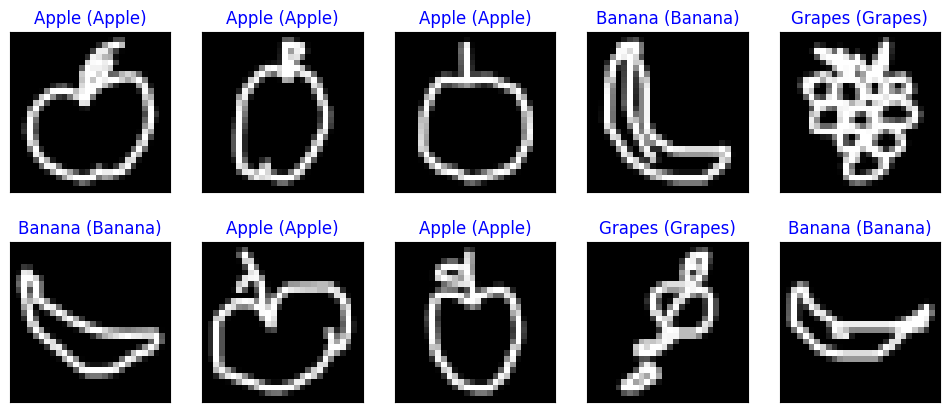

In [8]:
import matplotlib.pyplot as plt

# 시각화 함수 정의
def visualize_predictions(model, loader):
    model.eval()

    # 데이터 딱 1개 배치(64개)만 가져오기
    images, labels = next(iter(loader))
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # 클래스 이름 (0:사과, 1:바나나, 2:포도)
    class_names = ['Apple', 'Banana', 'Grapes']

    # 그림 그리기
    fig = plt.figure(figsize=(12, 5))
    for idx in range(10):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])

        # 흑백 이미지 출력
        ax.imshow(images[idx].squeeze(), cmap='gray')

        pred_label = class_names[preds[idx]]
        true_label = class_names[labels[idx]]
        color = 'blue' if pred_label == true_label else 'red'

        ax.set_title(f"{pred_label} ({true_label})", color=color)

    plt.show()

# 실행
visualize_predictions(model, test_loader)

In [9]:
# 모델 저장하기 (가중치만 저장)
torch.save(model.state_dict(), 'quickdraw_cnn.pth')
print("모델 저장: quickdraw_cnn.pth")

# (Colab에서 내 컴퓨터로 다운로드하려면)
from google.colab import files
files.download('quickdraw_cnn.pth')

💾 모델 저장이 완료되었습니다: quickdraw_cnn.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>